In [22]:
GSE_Train = "GSE63990"
target = "infection_status" #目标存的列。暂时还都不用改。

In [1]:
# 各种库导入
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier, Ridge, Lasso, LassoCV, LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
warnings.filterwarnings('ignore')

In [21]:
# 数据导入 及 预览数据. 输出末2行
gse = GEOparse.get_GEO(geo=GSE_Train, destdir="./datasets", silent=True)
gpls = gse.metadata['platform_id']
gpl = GEOparse.get_GEO(geo=gpls[0], destdir="./datasets", silent=True)
gse_csv = pd.read_csv('./datasets/' + GSE_Train + '.csv')
gse_csv.tail(2) # 预览数据

,gsm,infection_status,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
278,['GPL571'],bacterial,166.647984,146.071969,1743.577364,469.492725,14.195200,343.778134,50.751853,20.314978,...,14.887767,547.474236,809.473496,870.025309,2741.737234,1788.488809,10132.540601,6590.122263,22955.575917,22622.089415
279,['GPL571'],non-infectious illness,241.254257,97.798995,975.910432,670.694547,22.848622,415.702764,81.772657,24.304062,...,18.879299,2090.522459,3529.177301,3293.830703,7642.090690,6163.225703,16627.856948,13681.056327,25961.263712,27914.374857


In [19]:
# 选择的模型
up_feature =  ['ISG15', 'MX1', 'CD74']
up_weight =  [11,  8, 24]
up_times = 84694.59808314576
up_intercept = -2.8716859
up_model = LogisticRegression()
down_feature =  ['CD177', 'IL1R2', 'S100A12', 'MMP9']
down_weight = [14, 11, 24,  1]
down_times = 151481.89222583472
down_model = LogisticRegression()
down_intercept = -2.84741179

# 实际输入的模型
feature =  up_feature + down_feature
print('feature:', feature)
weight = up_weight + (np.array(down_weight) * -1).tolist()
print('weight:', weight)

feature: ['ISG15', 'MX1', 'CD74', 'CD177', 'IL1R2', 'S100A12', 'MMP9']
weight: [11, 8, 24, -14, -11, -24, -1]


In [31]:
# 仅选择特征和最终结果. 输出末2行
ID = []
for i in range(len(feature)):
    ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
ID.append(target)
ID = np.array(ID).reshape(-1)
ID.astype('str')
testdata = gse_csv[ID]
# 把testdata的columns的名字改成feature
testdata.columns = feature + ["target"]
testdata.tail(2)

,ISG15,MX1,CD74,CD177,IL1R2,S100A12,MMP9,target
278,766.806043,771.411707,1328.405327,16097.492305,14671.664893,16673.865467,24711.966685,bacterial
279,1013.083326,994.646616,3062.244505,1124.810009,1759.405540,4138.706147,8445.763125,non-infectious illness


In [33]:
# 计算每一种基因在不同感染情况下的表达量的平均值
testdata_mean = testdata.groupby("target").mean()
testdata_mean

,ISG15,MX1,CD74,CD177,IL1R2,S100A12,MMP9
target,,,,,,,
bacterial,1900.453653,2642.038821,5638.109571,9354.790294,7728.910999,11780.821871,12705.982299
non-infectious illness,2315.593269,2338.972378,4299.878600,2012.428555,3025.500611,4967.864984,6490.165870
viral,8815.201403,9462.416260,12899.823983,1770.743247,1458.642402,2674.060913,3439.678072


In [37]:
# 对平均值都乘以权重
testdata_mean_weight = testdata_mean * weight
testdata_mean_weight

,ISG15,MX1,CD74,CD177,IL1R2,S100A12,MMP9
target,,,,,,,
bacterial,20904.990178,21136.310571,135314.629711,-130967.064123,-85018.020984,-282739.724914,-12705.982299
non-infectious illness,25471.525956,18711.779023,103197.086396,-28173.999772,-33280.506719,-119228.759616,-6490.165870
viral,96967.215438,75699.330078,309595.775598,-24790.405456,-16045.066424,-64177.461914,-3439.678072


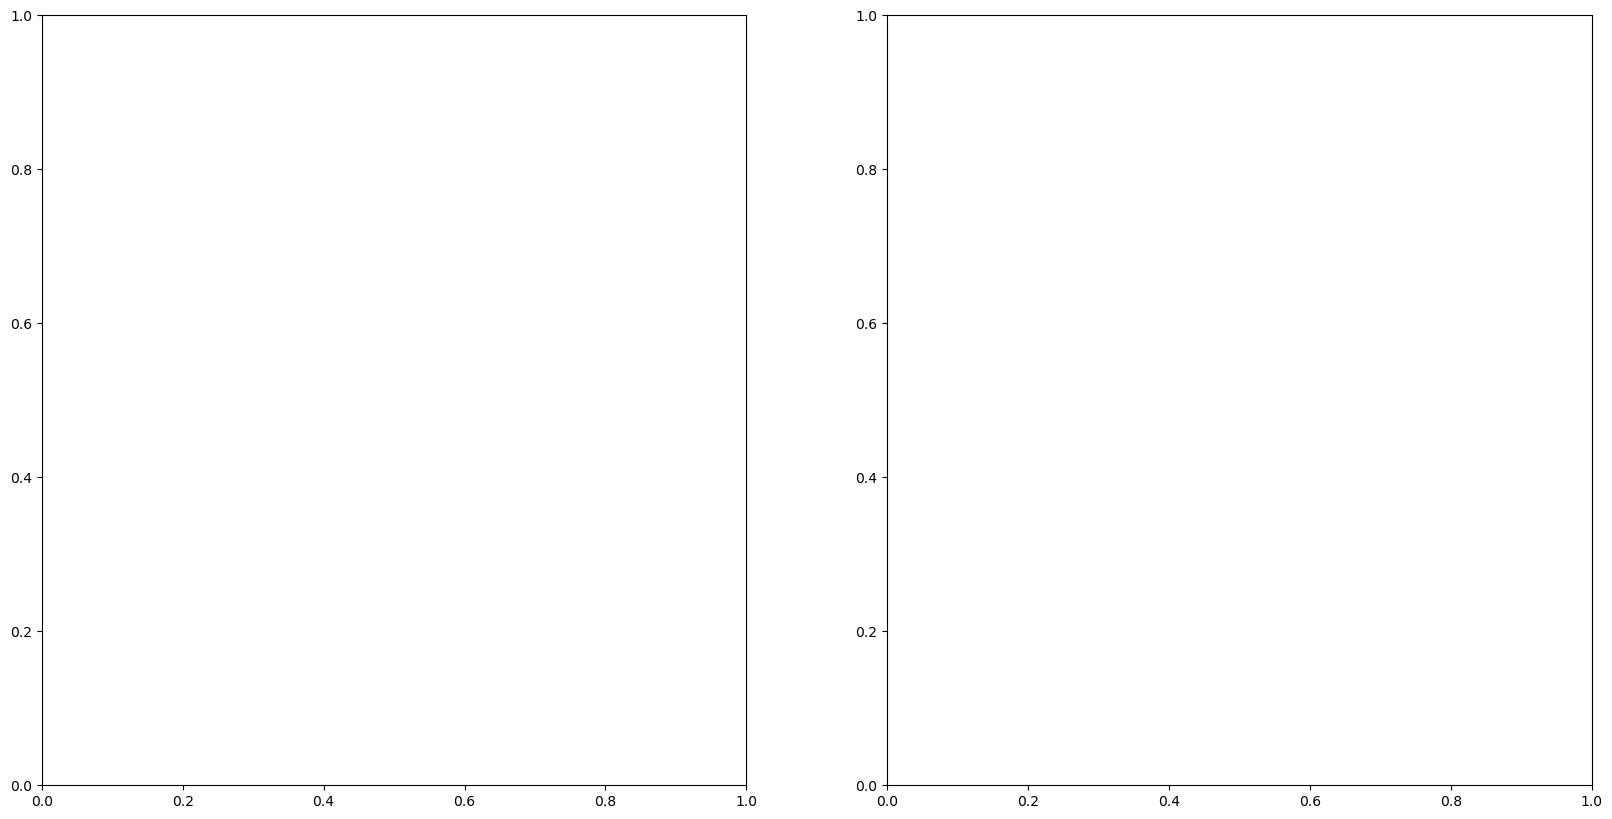

In [52]:
# 后面就是画图的部分了。 具体可以看 https://seaborn.pydata.org/tutorial.html
# 直接问ai也可以。 比如 https://www.phind.com/
# https://seaborn.pydata.org/tutorial/axis_grids.html 比如这个下面的几个例子都可以参考
fig, ax = plt.subplots(1,2, figsize=(20, 10)) # 画布大小横为20，纵为10，一共1行2列